In [2]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_parquet('/home/jupyter/datasphere/project/train_dataset_hackaton2023_train.gzip')

In [3]:
df_train = df_train.drop(columns=['group_name'])

In [4]:
df_train.dtypes

customer_id                int64
date_diff_post           float64
buy_post                   int64
revenue                  float64
startdatetime     datetime64[ns]
dish_name                 object
ownareaall_sqm           float64
format_name               object
dtype: object

Models

In [5]:
'''from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df_train['dish_name'])
df_train['dish_name'] = label_encoder.transform(df_train['dish_name'])

df_train.head()'''

"from sklearn import preprocessing\nlabel_encoder = preprocessing.LabelEncoder()\nlabel_encoder.fit(df_train['dish_name'])\ndf_train['dish_name'] = label_encoder.transform(df_train['dish_name'])\n\ndf_train.head()"

In [6]:
df_train['prev_id']=df_train.customer_id.shift()
df_train['prev_time'] = df_train.startdatetime.shift()

In [7]:
df_train['until_days'] = (df_train['startdatetime'].sub(df_train['prev_time']).dt.days) + (df_train['startdatetime'].sub(df_train['prev_time']).dt.seconds/3600/24)

In [8]:
df_train.loc[(df_train.customer_id != df_train.prev_id).to_list(), 'until_days'] = 0

In [9]:
df_train.head(40)

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,prev_id,prev_time,until_days
0,29891,9.0,1,69.99,2022-12-05 12:03:58,Кинг Фри станд,300.0,Отдельно стоящий без внешней зоны,NaN,NaT,0.000000
1,29891,9.0,1,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000
2,29891,9.0,1,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000
3,29891,9.0,1,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000
4,29891,9.0,1,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.100428
5,29891,9.0,1,60.00,2022-12-15 00:37:19,Чизбургер,463.0,Отдельно стоящий с внешней зоной,29891.0,2022-12-05 14:28:35,9.422731
6,29891,9.0,1,209.99,2022-12-15 00:37:19,Воппер Ролл,463.0,Отдельно стоящий с внешней зоной,29891.0,2022-12-15 00:37:19,0.000000
7,29891,9.0,1,144.97,2022-12-20 09:20:38,ЧизБекон Чикен Гамбургер,463.0,Отдельно стоящий с внешней зоной,29891.0,2022-12-15 00:37:19,5.363414
8,29891,9.0,1,184.96,2022-12-21 09:46:23,Цезарь Кинг новый,463.0,Отдельно стоящий с внешней зоной,29891.0,2022-12-20 09:20:38,1.017882
9,29891,9.0,1,84.99,2022-12-21 13:12:09,Flash Up,463.0,Отдельно стоящий с внешней зоной,29891.0,2022-12-21 09:46:23,0.142894


In [10]:
df_train['day_of_week'] = df_train['startdatetime'].dt.dayofweek
df_train['hour'] = df_train['startdatetime'].dt.hour
df_train['is_morning'] = 0
df_train['is_day'] = 0
df_train['is_evening'] = 0
df_train['is_night'] = 0
def time_split(row):
  if row['hour'] < 6:
    row['is_night'] = 1
    return row
  if row['hour'] < 12:
    row['is_morning'] = 1
    return row
  if row['hour'] < 18:
    row['is_day'] = 1
    return row
  else:
    row['is_evening'] = 1
    return row
df_train = df_train.apply(time_split, axis = 1)

IOStream.flush timed out


In [11]:
df_train['dish_name'] = df_train['dish_name'].replace(regex = r'Кинг Фри[\s\w]*', value = 'фри')
import re
fries = re.compile(r"[\s\w\W]*(фри|карт)", re.I)
burgers = re.compile(r"[\s\w\W]*(воппер|бургер|ролл|кинг|ангус|тар-тар|гранд|бекон|стейк|BBQ|пармезан)", re.I)
deserts = re.compile(r"[\s\w\W]*(сандэй|брауни|рожок|айс твист|маффин|улитка|батончик|морожен)", re.I)
cold_drinks = re.compile(r"[\s\w\W]*(нап|0,2|0,3|0,4|0,5|0.5|0,8|1л|шейк|flash|нап|пиво|балтика|сок|джун$)", re.I)
hot_drinks = re.compile(r"[\s\w\W]*(латте|капучино|кофе|эспрессо|чай|какао)", re.I)
snacks = re.compile(r"[\s\w\W]*(шт|начос|салат|чипсы|конверт|сухарики|микс|шейкер)", re.I)
sauces = re.compile(r"[\s\w\W]*(соус|кетчуп)", re.I)
kids = re.compile(r"[\s\w\W]*А4", re.I)

spicy = re.compile(r"[\s\w\W]*остр", re.I)
cheese = re.compile(r"[\s\w\W]*сыр", re.I)
double = re.compile(r"[\s\w\W]*ной", re.I)
chicken = re.compile(r"[\s\w\W]*(кур|чикен)", re.I)
fish = re.compile(r"[\s\w\W]*(шримп|фиш|крев)", re.I)

types_list = [fries, burgers, deserts, hot_drinks, snacks, sauces, kids, cold_drinks]
types_name = ['fries', 'burgers', 'snacks', 'sauces', 'kids', 'cold_drinks', 'deserts', 'hot_drinks']
flavours_list = [spicy, cheese, double, chicken, fish]
flavours_name = ['spicy', 'cheese', 'double', 'chicken', 'fish']

for dish_type in types_name:
  df_train['contains_' + dish_type] = 0
for flavour_type in flavours_name:
  df_train[flavour_type + '_flavour'] = 0

def categories_split(row):
  dish = row['dish_name']
  for dish_type_index in range(len(types_list)):
    if re.match(types_list[dish_type_index], row['dish_name']):
      row['contains_' + types_name[dish_type_index]] = 1
      if dish_type_index < 3:
        for flavour_index in range(len(flavours_list)):
          if re.match(flavours_list[flavour_index], row['dish_name']):
            row[flavours_name[flavour_index] + '_flavour'] = 1
            return row
      return row
  return row

df_train = df_train.apply(categories_split, axis = 1)

IOStream.flush timed out


In [12]:
df_train

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,prev_id,prev_time,until_days,day_of_week,hour,is_morning,is_day,is_evening,is_night,contains_fries,contains_burgers,contains_snacks,contains_sauces,contains_kids,contains_cold_drinks,contains_deserts,contains_hot_drinks,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
0,29891,9.0,1,69.99,2022-12-05 12:03:58,фри,300.0,Отдельно стоящий без внешней зоны,NaN,NaT,0.000000,0,12,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,29891,9.0,1,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000,0,12,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,29891,9.0,1,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000,0,12,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,29891,9.0,1,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000,0,12,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,29891,9.0,1,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.100428,0,14,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24261974,46661804,NaN,0,7.99,2023-08-01 18:04:56,"Эвервесс Кола джун 0,3л",300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.000000,1,18,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
24261975,46661804,NaN,0,84.98,2023-08-01 18:04:56,Воппер Джуниор,300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.000000,1,18,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
24261976,46661804,NaN,0,70.03,2023-08-01 18:04:56,Наггетсы (3 шт.),300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.000000,1,18,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
24261977,46661804,NaN,0,19.00,2023-08-01 18:04:56,Сырные Медальоны (3 шт.),300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.000000,1,18,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [145]:
df_copy = df_train.copy()

In [146]:
df_copy = df_copy.rename(columns={'contains_snacks':'contains_deserts', 'contains_sauces':'contains_hot_drinks', \
                        'contains_kids':'contains_snacks', 'contains_cold_drinks':'contains_sauces', 'contains_deserts':'contains_kids', \
                        'contains_hot_drinks':'contains_cold_drinks'})

In [147]:
df_copy.loc[(df_copy.contains_kids == 0) & (df_copy.contains_burgers == 0) & (df_copy.contains_snacks == 0) & (df_copy.contains_cold_drinks == 0) & (df_copy.contains_hot_drinks == 0) & (df_copy.contains_fries == 0) & (df_copy.contains_sauces == 0)& (df_copy.contains_deserts == 0)]['dish_name'].value_counts()
df_copy.loc[df_copy.contains_kids == 1]

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,prev_id,prev_time,until_days,day_of_week,hour,is_morning,is_day,is_evening,is_night,contains_fries,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,contains_cold_drinks,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
177,31426,4.0,1,85.00,2023-06-05 11:25:53,А4 ЛИПУН,153.00,Фудкорт без туалета,31426.0,2023-06-05 11:25:53,0.0,0,11,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2113,157470,NaN,0,85.00,2022-12-07 18:27:32,А4 ЛОКЕР,89.30,Фудкорт без туалета,157470.0,2022-12-07 18:27:32,0.0,2,18,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6246,197989,46.0,1,85.00,2022-12-22 13:29:52,А4 ЛОКЕР,60.80,Фудкорт без туалета,197989.0,2022-12-22 13:29:52,0.0,3,13,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6259,197989,46.0,1,85.00,2022-12-28 20:21:21,А4 ЛОКЕР,60.80,Фудкорт без туалета,197989.0,2022-12-28 20:21:21,0.0,2,20,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6268,197989,46.0,1,85.00,2023-01-15 16:09:23,А4 ЛОКЕР,88.42,Фудкорт без туалета,197989.0,2023-01-15 16:09:23,0.0,6,16,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24261391,46540364,NaN,0,189.99,2023-07-28 19:44:34,А4 СТУДИЯ,230.80,Отдельно стоящий без внешней зоны,46540364.0,2023-07-28 19:44:34,0.0,4,19,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
24261417,46558168,17.0,1,85.00,2023-07-29 12:12:32,А4 ЛИПУН,315.70,Отдельно стоящий с внешней зоной,46558168.0,2023-07-29 12:12:32,0.0,5,12,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
24261419,46558168,17.0,1,85.00,2023-07-29 12:12:32,А4 ЛИПУН,315.70,Отдельно стоящий с внешней зоной,46558168.0,2023-07-29 12:12:32,0.0,5,12,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
24261512,46566688,37.0,1,85.00,2023-07-29 18:44:14,А4 ЛИПУН,83.35,Фудкорт без туалета,46566688.0,2023-07-29 18:44:14,0.0,5,18,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [148]:
df_copy.tail()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,prev_id,prev_time,until_days,day_of_week,hour,is_morning,is_day,is_evening,is_night,contains_fries,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,contains_cold_drinks,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
24261974,46661804,NaN,0,7.99,2023-08-01 18:04:56,"Эвервесс Кола джун 0,3л",300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.0,1,18,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
24261975,46661804,NaN,0,84.98,2023-08-01 18:04:56,Воппер Джуниор,300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.0,1,18,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
24261976,46661804,NaN,0,70.03,2023-08-01 18:04:56,Наггетсы (3 шт.),300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.0,1,18,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
24261977,46661804,NaN,0,19.00,2023-08-01 18:04:56,Сырные Медальоны (3 шт.),300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.0,1,18,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
24261978,46661804,NaN,0,17.99,2023-08-01 18:04:56,фри,300.0,Фудкорт с туалетом,46661804.0,2023-08-01 18:04:56,0.0,1,18,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
df_copy = df_copy.fillna(value=100)

In [150]:
df_copy.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,prev_id,prev_time,until_days,day_of_week,hour,is_morning,is_day,is_evening,is_night,contains_fries,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,contains_cold_drinks,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
0,29891,9.0,1,69.99,2022-12-05 12:03:58,фри,300.0,Отдельно стоящий без внешней зоны,100.0,100,0.000000,0,12,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,29891,9.0,1,190.00,2022-12-05 12:03:58,Чикен Тар-Тар,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000,0,12,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,29891,9.0,1,9.99,2022-12-05 12:03:58,Соус Сырный,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000,0,12,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,29891,9.0,1,119.99,2022-12-05 12:03:58,Энергет.нап. Адреналин Раш,300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.000000,0,12,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,29891,9.0,1,119.99,2022-12-05 14:28:35,Латте (СТАНД.),300.0,Отдельно стоящий без внешней зоны,29891.0,2022-12-05 12:03:58,0.100428,0,14,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [151]:
df_copy = df_copy.drop(columns=['prev_id', 'prev_time', 'dish_name']) 

In [152]:
df_copy = pd.get_dummies(df_copy, columns =['day_of_week'])

In [153]:
df_copy.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,ownareaall_sqm,format_name,until_days,hour,is_morning,is_day,is_evening,is_night,contains_fries,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,contains_cold_drinks,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,29891,9.0,1,69.99,2022-12-05 12:03:58,300.0,Отдельно стоящий без внешней зоны,0.000000,12,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,29891,9.0,1,190.00,2022-12-05 12:03:58,300.0,Отдельно стоящий без внешней зоны,0.000000,12,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,29891,9.0,1,9.99,2022-12-05 12:03:58,300.0,Отдельно стоящий без внешней зоны,0.000000,12,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,29891,9.0,1,119.99,2022-12-05 12:03:58,300.0,Отдельно стоящий без внешней зоны,0.000000,12,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,29891,9.0,1,119.99,2022-12-05 14:28:35,300.0,Отдельно стоящий без внешней зоны,0.100428,14,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [154]:
agg_func = {'until_days': 'sum', 'revenue': 'sum', 'contains_fries': 'sum','contains_cold_drinks': 'sum', 'contains_burgers': 'sum', 'contains_deserts': 'sum',\
           'contains_hot_drinks': 'sum', 'contains_snacks': 'sum', 'contains_sauces': 'sum', 'contains_kids': 'max', 'spicy_flavour': 'sum', 'cheese_flavour': 'sum',\
           'double_flavour': 'sum','chicken_flavour': 'sum','fish_flavour': 'sum'}

In [155]:
df_copy = df_copy.groupby(['customer_id', 'date_diff_post', 'buy_post', 'startdatetime', 'ownareaall_sqm', 'format_name', \
                'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',\
                'is_morning', 'is_day', 'is_night', 'is_evening']).agg(agg_func).reset_index().fillna(0)

In [156]:
df_copy.head()

,customer_id,date_diff_post,buy_post,ownareaall_sqm,format_name,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
0,29891,9.0,1,300.0,Отдельно стоящий без внешней зоны,1,0,0,0,0,0,0,0,1,0,0,0.000000,389.97,1,1,1,0,0,0,1,0,0,0,0,1,0
1,29891,9.0,1,300.0,Отдельно стоящий без внешней зоны,1,0,0,0,0,0,0,0,1,0,0,0.100428,119.99,0,0,0,0,1,0,0,0,0,0,0,0,0
2,29891,9.0,1,463.0,Отдельно стоящий с внешней зоной,0,0,0,1,0,0,0,0,0,1,0,9.422731,269.99,0,0,2,0,0,0,0,0,0,0,0,0,0
3,29891,9.0,1,463.0,Отдельно стоящий с внешней зоной,0,1,0,0,0,0,0,1,0,0,0,5.363414,144.97,0,0,1,0,0,0,0,0,0,0,0,1,0
4,29891,9.0,1,463.0,Отдельно стоящий с внешней зоной,0,0,1,0,0,0,0,1,0,0,0,1.017882,184.96,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880581,46654016,15.0,1,270.0,Отдельно стоящий с внешней зоной,0,1,0,0,0,0,0,0,1,0,0,0.076979,179.99,0,1,0,0,0,0,0,0,0,0,0,0,0
2880582,46654016,15.0,1,270.0,Отдельно стоящий с внешней зоной,0,1,0,0,0,0,0,0,0,0,1,0.174340,569.98,0,1,1,0,0,0,0,0,0,0,0,0,0
2880583,46661804,100.0,0,300.0,Фудкорт с туалетом,0,1,0,0,0,0,0,0,1,0,0,0.000000,259.99,1,1,1,0,0,0,0,0,0,0,1,0,0
2880584,46661804,100.0,0,300.0,Фудкорт с туалетом,0,1,0,0,0,0,0,0,0,0,1,0.007801,284.97,1,1,1,1,0,2,0,0,0,0,0,0,0


--------------Интервальные фичи

In [157]:
agg_func = {'until_days': ['mean', 'median', 'max', 'std'], 'revenue':['mean', 'median', 'max','min','std']}
df_copy1 = df_copy.groupby(['customer_id']).agg(agg_func).reset_index()

In [158]:
df_copy1.columns = df_copy1.columns.droplevel(0)

In [159]:
df_copy1 = df_copy1.rename(columns = {'':'customer_id'})

In [160]:
df_copy1.head()

,customer_id,mean,median,max,std,mean,median,max,min,std
0,29891,2.316445,1.002199,11.122106,3.022503,203.494000,199.960,439.98,1.00,123.170275
1,30477,2.079109,0.962685,9.040428,2.524210,227.024000,229.990,499.95,44.99,124.933425
2,31426,2.091698,1.466279,6.871424,1.945584,391.399583,344.985,1079.97,1.00,334.849322
3,44491,6.960298,0.489444,26.862303,13.275730,128.725000,59.980,344.97,49.97,144.471912
4,44939,5.149244,7.181852,8.265880,4.492195,554.943333,554.940,604.93,504.96,49.985000


In [162]:
df_copy.head()

,customer_id,date_diff_post,buy_post,startdatetime,ownareaall_sqm,format_name,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
0,29891,9.0,1,2022-12-05 12:03:58,300.0,Отдельно стоящий без внешней зоны,1,0,0,0,0,0,0,0,1,0,0,0.000000,389.97,1,1,1,0,0,0,1,0,0,0,0,1,0
1,29891,9.0,1,2022-12-05 14:28:35,300.0,Отдельно стоящий без внешней зоны,1,0,0,0,0,0,0,0,1,0,0,0.100428,119.99,0,0,0,0,1,0,0,0,0,0,0,0,0
2,29891,9.0,1,2022-12-15 00:37:19,463.0,Отдельно стоящий с внешней зоной,0,0,0,1,0,0,0,0,0,1,0,9.422731,269.99,0,0,2,0,0,0,0,0,0,0,0,0,0
3,29891,9.0,1,2022-12-20 09:20:38,463.0,Отдельно стоящий с внешней зоной,0,1,0,0,0,0,0,1,0,0,0,5.363414,144.97,0,0,1,0,0,0,0,0,0,0,0,1,0
4,29891,9.0,1,2022-12-21 09:46:23,463.0,Отдельно стоящий с внешней зоной,0,0,1,0,0,0,0,1,0,0,0,1.017882,184.96,0,0,1,0,0,0,0,0,0,0,0,0,0


In [163]:
df_copy = df_copy.merge(df_copy1, on='customer_id', how='inner')

In [164]:
df_copy.columns

Index(['customer_id', 'date_diff_post', 'buy_post', 'startdatetime',
       'ownareaall_sqm', 'format_name', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'is_morning', 'is_day', 'is_night', 'is_evening',
       'until_days', 'revenue', 'contains_fries', 'contains_cold_drinks',
       'contains_burgers', 'contains_deserts', 'contains_hot_drinks',
       'contains_snacks', 'contains_sauces', 'contains_kids', 'spicy_flavour',
       'cheese_flavour', 'double_flavour', 'chicken_flavour', 'fish_flavour',
       'mean', 'median', 'max', 'std', 'mean', 'median', 'max', 'min', 'std'],
      dtype='object')

In [165]:
(df_copy.buy_post==0).sum()

587833

In [166]:
df_copy.tail(5)

,customer_id,date_diff_post,buy_post,startdatetime,ownareaall_sqm,format_name,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean,median,max,min,std
2880581,46654016,15.0,1,2023-08-01 14:04:28,270.0,Отдельно стоящий с внешней зоной,0,1,0,0,0,0,0,0,1,0,0,0.076979,179.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140
2880582,46654016,15.0,1,2023-08-01 18:15:31,270.0,Отдельно стоящий с внешней зоной,0,1,0,0,0,0,0,0,0,0,1,0.174340,569.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140
2880583,46661804,100.0,0,2023-08-01 17:50:26,300.0,Фудкорт с туалетом,0,1,0,0,0,0,0,0,1,0,0,0.000000,259.99,1,1,1,0,0,0,0,0,0,0,1,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345
2880584,46661804,100.0,0,2023-08-01 18:01:40,300.0,Фудкорт с туалетом,0,1,0,0,0,0,0,0,0,0,1,0.007801,284.97,1,1,1,1,0,2,0,0,0,0,0,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345
2880585,46661804,100.0,0,2023-08-01 18:04:56,300.0,Фудкорт с туалетом,0,1,0,0,0,0,0,0,0,0,1,0.002269,289.97,1,1,1,1,0,2,0,0,0,0,0,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345


In [167]:
ser = df_copy.groupby(['format_name']).mean()['ownareaall_sqm']
df_copy['ownareaall_sqm'] = df_copy.apply(lambda x: x['ownareaall_sqm'] if (x['ownareaall_sqm'] != 0) else (ser[str(x['format_name'])]), axis = 1)
df_copy = pd.get_dummies(df_copy, columns =['format_name'])

<ipython-input-167-e9b12ab0a424>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ser = df_copy.groupby(['format_name']).mean()['ownareaall_sqm']


In [174]:
df_copy

,customer_id,date_diff_post,buy_post,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean,median,max,min,std,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,29891,9.0,1,300.0,1,0,0,0,0,0,0,0,1,0,0,0.000000,389.97,1,1,1,0,0,0,1,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,1,0,0,0,0,0,0
1,29891,9.0,1,300.0,1,0,0,0,0,0,0,0,1,0,0,0.100428,119.99,0,0,0,0,1,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,1,0,0,0,0,0,0
2,29891,9.0,1,463.0,0,0,0,1,0,0,0,0,0,1,0,9.422731,269.99,0,0,2,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,0,0,0,0,1,0,0
3,29891,9.0,1,463.0,0,1,0,0,0,0,0,1,0,0,0,5.363414,144.97,0,0,1,0,0,0,0,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,0,0,0,0,1,0,0
4,29891,9.0,1,463.0,0,0,1,0,0,0,0,1,0,0,0,1.017882,184.96,0,0,1,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880581,46654016,15.0,1,270.0,0,1,0,0,0,0,0,0,1,0,0,0.076979,179.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140,0,0,0,0,0,1,0,0
2880582,46654016,15.0,1,270.0,0,1,0,0,0,0,0,0,0,0,1,0.174340,569.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140,0,0,0,0,0,1,0,0
2880583,46661804,100.0,0,300.0,0,1,0,0,0,0,0,0,1,0,0,0.000000,259.99,1,1,1,0,0,0,0,0,0,0,1,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345,0,0,0,0,0,0,0,1
2880584,46661804,100.0,0,300.0,0,1,0,0,0,0,0,0,0,0,1,0.007801,284.97,1,1,1,1,0,2,0,0,0,0,0,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345,0,0,0,0,0,0,0,1


In [169]:
df_copy = df_copy.drop(columns = ['startdatetime', 'format_name_Не заполнено'])

In [172]:
(df_copy.ownareaall_sqm==0).sum()

0

In [173]:
df_copy.to_csv('df_train1.csv', index =False)

НОРМАЛИЗАЦИЯ

In [3]:
df = pd.read_csv('/home/jupyter/datasphere/project/df_train1.csv')

In [4]:
X = df.drop(columns=['buy_post', 'date_diff_post', 'customer_id'])
y = df.buy_post
ids = df.customer_id

In [179]:
X.head()

,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean,median,max,min,std,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,300.0,1,0,0,0,0,0,0,0,1,0,0,0.000000,389.97,1,1,1,0,0,0,1,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,1,0,0,0,0,0,0
1,300.0,1,0,0,0,0,0,0,0,1,0,0,0.100428,119.99,0,0,0,0,1,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,1,0,0,0,0,0,0
2,463.0,0,0,0,1,0,0,0,0,0,1,0,9.422731,269.99,0,0,2,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,0,0,0,0,1,0,0
3,463.0,0,1,0,0,0,0,0,1,0,0,0,5.363414,144.97,0,0,1,0,0,0,0,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,0,0,0,0,1,0,0
4,463.0,0,0,1,0,0,0,0,1,0,0,0,1.017882,184.96,0,0,1,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,0,0,0,0,1,0,0


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)

In [184]:
type(X_norm)

numpy.ndarray

In [6]:
X_norm = pd.DataFrame(X_norm)

In [189]:
#X_norm['customer_id']=pd.Series(ids)

ОБУЧЕНИЕ

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_val)
y_pred_proba = log.predict_proba(X_val)
f1_score(y_val, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8859969621878435

In [35]:
probs = pd.DataFrame(y_pred_proba, columns = ['prob_0', 'prob_1'])

In [36]:
probs['customer_id'] = pd.Series(ids)
probs['date_diff_post'] = 1

In [37]:
probs.head()

,prob_0,prob_1,customer_id,date_diff_post
0,0.203768,0.796232,29891,1
1,0.168426,0.831574,29891,1
2,0.182230,0.817770,29891,1
3,0.196736,0.803264,29891,1
4,0.239780,0.760220,29891,1


In [38]:
agg_func_probs = {'prob_0': 'mean', 'prob_1': 'mean'}
probs = probs.groupby(['customer_id', 'date_diff_post']).agg(agg_func_probs).reset_index()

In [39]:
probs

,customer_id,date_diff_post,prob_0,prob_1
0,29891,1,0.200081,0.799919
1,30477,1,0.203953,0.796047
2,31426,1,0.204703,0.795297
3,44491,1,0.189460,0.810540
4,44939,1,0.222571,0.777429
...,...,...,...,...
99471,8610377,1,0.229318,0.770682
99472,8610382,1,0.191569,0.808431
99473,8610527,1,0.183433,0.816567
99474,8610647,1,0.200319,0.799681


In [40]:
probs['buy_post'] = probs.apply(lambda x: 0 if x.prob_0 >= 0.5 else 1, axis = 1)

In [41]:
probs['prob_score'] = probs.prob_1

In [42]:
probs = probs.drop(columns=['prob_1', 'prob_0'])

In [43]:
probs.head()

,customer_id,date_diff_post,buy_post,prob_score
0,29891,1,1,0.799919
1,30477,1,1,0.796047
2,31426,1,1,0.795297
3,44491,1,1,0.810540
4,44939,1,1,0.777429


Тестовые данные

In [3]:
df_test = pd.read_parquet('/home/jupyter/datasphere/project/hackaton2023_test.gzip')

In [4]:
df_test = df_test.sort_values(['customer_id','startdatetime'], ascending=[True, True])
df_test['prev_id']=df_test.customer_id.shift()
df_test['prev_time'] = df_test.startdatetime.shift()
df_test['until_days'] = (df_test['startdatetime'].sub(df_test['prev_time']).dt.days) + (df_test['startdatetime'].sub(df_test['prev_time']).dt.seconds/3600/24)
df_test.loc[(df_test.customer_id != df_test.prev_id).to_list(), 'until_days'] = 0
df_test = df_test.drop(columns=['group_name','prev_id', 'prev_time'])

In [5]:
df_test.head()

,customer_id,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,until_days
26,52341,54.00,2023-02-04 13:13:06,Кинг Фри станд,338.9,Отдельно стоящий с внешней зоной,0.0
28,52341,54.99,2023-02-04 13:13:06,Рожок,338.9,Отдельно стоящий с внешней зоной,0.0
27,52341,96.00,2023-02-04 13:13:06,"Лимонад б/л мал 0,4",338.9,Отдельно стоящий с внешней зоной,0.0
29,52341,99.99,2023-02-04 13:13:06,Наггетсы (6 шт.),338.9,Отдельно стоящий с внешней зоной,0.0
30,52341,89.99,2023-02-04 13:13:06,Чикенбургер новый,338.9,Отдельно стоящий с внешней зоной,0.0


In [7]:
df_test['day_of_week'] = df_test['startdatetime'].dt.dayofweek
df_test['hour'] = df_test['startdatetime'].dt.hour
df_test['is_morning'] = 0
df_test['is_day'] = 0
df_test['is_evening'] = 0
df_test['is_night'] = 0
def time_split(row):
  if row['hour'] < 6:
    row['is_night'] = 1
    return row
  if row['hour'] < 12:
    row['is_morning'] = 1
    return row
  if row['hour'] < 18:
    row['is_day'] = 1
    return row
  else:
    row['is_evening'] = 1
    return row
df_test = df_test.apply(time_split, axis = 1)

In [8]:
df_test

,customer_id,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,until_days,day_of_week,hour,is_morning,is_day,is_evening,is_night
26,52341,54.00,2023-02-04 13:13:06,Кинг Фри станд,338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
28,52341,54.99,2023-02-04 13:13:06,Рожок,338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
27,52341,96.00,2023-02-04 13:13:06,"Лимонад б/л мал 0,4",338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
29,52341,99.99,2023-02-04 13:13:06,Наггетсы (6 шт.),338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
30,52341,89.99,2023-02-04 13:13:06,Чикенбургер новый,338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
24,52341,44.99,2023-02-04 13:13:06,Соус Сырный,338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
25,52341,109.99,2023-02-04 13:13:06,Кофе (СТАНД.),338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
31,52341,54.99,2023-02-11 13:08:33,Рожок,338.9,Отдельно стоящий с внешней зоной,6.996840,5,13,0,1,0,0
35,52341,89.99,2023-02-11 13:08:33,Чикенбургер новый,338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0
32,52341,54.00,2023-02-11 13:08:33,Кинг Фри станд,338.9,Отдельно стоящий с внешней зоной,0.000000,5,13,0,1,0,0


In [10]:
df_test['dish_name'] = df_test['dish_name'].replace(regex = r'Кинг Фри[\s\w]*', value = 'фри')
import re
fries = re.compile(r"[\s\w\W]*(фри|карт)", re.I)
burgers = re.compile(r"[\s\w\W]*(воппер|бургер|ролл|кинг|ангус|тар-тар|гранд|бекон|стейк|BBQ|пармезан)", re.I)
deserts = re.compile(r"[\s\w\W]*(сандэй|брауни|рожок|айс твист|маффин|улитка|батончик|морожен)", re.I)
cold_drinks = re.compile(r"[\s\w\W]*(нап|0,2|0,3|0,4|0,5|0.5|0,8|1л|шейк|flash|нап|пиво|балтика|сок|джун$)", re.I)
hot_drinks = re.compile(r"[\s\w\W]*(латте|капучино|кофе|эспрессо|чай|какао)", re.I)
snacks = re.compile(r"[\s\w\W]*(шт|начос|салат|чипсы|конверт|сухарики|микс|шейкер)", re.I)
sauces = re.compile(r"[\s\w\W]*(соус|кетчуп)", re.I)
kids = re.compile(r"[\s\w\W]*А4", re.I)

spicy = re.compile(r"[\s\w\W]*остр", re.I)
cheese = re.compile(r"[\s\w\W]*сыр", re.I)
double = re.compile(r"[\s\w\W]*ной", re.I)
chicken = re.compile(r"[\s\w\W]*(кур|чикен)", re.I)
fish = re.compile(r"[\s\w\W]*(шримп|фиш|крев)", re.I)

types_list = [fries, burgers, deserts, hot_drinks, snacks, sauces, kids, cold_drinks]
types_name = ['fries', 'burgers', 'snacks', 'sauces', 'kids', 'cold_drinks', 'deserts', 'hot_drinks']
flavours_list = [spicy, cheese, double, chicken, fish]
flavours_name = ['spicy', 'cheese', 'double', 'chicken', 'fish']

for dish_type in types_name:
  df_test['contains_' + dish_type] = 0
for flavour_type in flavours_name:
  df_test[flavour_type + '_flavour'] = 0

def categories_split(row):
  dish = row['dish_name']
  for dish_type_index in range(len(types_list)):
    if re.match(types_list[dish_type_index], row['dish_name']):
      row['contains_' + types_name[dish_type_index]] = 1
      if dish_type_index < 3:
        for flavour_index in range(len(flavours_list)):
          if re.match(flavours_list[flavour_index], row['dish_name']):
            row[flavours_name[flavour_index] + '_flavour'] = 1
            return row
      return row
  return row

df_test = df_test.apply(categories_split, axis = 1)

In [31]:
df_copy1 = df_test.copy()
df_copy1 = df_copy1.rename(columns={'contains_snacks':'contains_deserts', 'contains_sauces':'contains_hot_drinks', \
                        'contains_kids':'contains_snacks', 'contains_cold_drinks':'contains_sauces', 'contains_deserts':'contains_kids', \
                        'contains_hot_drinks':'contains_cold_drinks'})

In [32]:
df_copy1.head()

,customer_id,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,until_days,day_of_week,hour,is_morning,is_day,is_evening,is_night,contains_fries,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,contains_cold_drinks,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
26,52341,54.00,2023-02-04 13:13:06,фри,338.9,Отдельно стоящий с внешней зоной,0.0,5,13,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
28,52341,54.99,2023-02-04 13:13:06,Рожок,338.9,Отдельно стоящий с внешней зоной,0.0,5,13,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
27,52341,96.00,2023-02-04 13:13:06,"Лимонад б/л мал 0,4",338.9,Отдельно стоящий с внешней зоной,0.0,5,13,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
29,52341,99.99,2023-02-04 13:13:06,Наггетсы (6 шт.),338.9,Отдельно стоящий с внешней зоной,0.0,5,13,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
30,52341,89.99,2023-02-04 13:13:06,Чикенбургер новый,338.9,Отдельно стоящий с внешней зоной,0.0,5,13,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [33]:
df_copy1.loc[(df_copy1.contains_kids == 0) & (df_copy1.contains_burgers == 0) & (df_copy1.contains_snacks == 0) & (df_copy1.contains_cold_drinks == 0) & (df_copy1.contains_hot_drinks == 0) & (df_copy1.contains_fries == 0) & (df_copy1.contains_sauces == 0)& (df_copy1.contains_deserts == 0)]['dish_name'].value_counts()

Влажная салфетка                          27089
3D-ПАТЧ                                    1837
Комплект Стикстеров                        1829
Пакет                                       726
Жевательная резинка Орбит сладкая мята      554
Жевательная резинка Орбит bubblemint        392
Джуниор Корона                              328
Пакет Новый                                 118
Игрушка                                      12
Игрушка Mattel                               10
Антисептик Армасепт Гель                     10
ДОГПЕР                                        2
Name: dish_name, dtype: int64

In [34]:
df_copy1 = df_copy1.drop(columns=['dish_name']) 
df_copy1 = pd.get_dummies(df_copy1, columns =['day_of_week'])
agg_func = {'until_days': 'sum', 'revenue': 'sum', 'contains_fries': 'sum','contains_cold_drinks': 'sum', 'contains_burgers': 'sum', 'contains_deserts': 'sum',\
           'contains_hot_drinks': 'sum', 'contains_snacks': 'sum', 'contains_sauces': 'sum', 'contains_kids': 'max', 'spicy_flavour': 'sum', 'cheese_flavour': 'sum',\
           'double_flavour': 'sum','chicken_flavour': 'sum','fish_flavour': 'sum'}
df_copy1 = df_copy1.groupby(['customer_id', 'startdatetime', 'ownareaall_sqm', 'format_name', \
                'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',\
                'is_morning', 'is_day', 'is_night', 'is_evening']).agg(agg_func).reset_index().fillna(0)
df_copy1.head()


,customer_id,startdatetime,ownareaall_sqm,format_name,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour
0,52341,2023-02-04 13:13:06,338.9,Отдельно стоящий с внешней зоной,0,0,0,0,0,1,0,0,1,0,0,0.000000,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0
1,52341,2023-02-11 13:08:33,338.9,Отдельно стоящий с внешней зоной,0,0,0,0,0,1,0,0,1,0,0,6.996840,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0
2,52341,2023-02-18 14:10:14,338.9,Отдельно стоящий с внешней зоной,0,0,0,0,0,1,0,0,1,0,0,7.042836,499.94,1,0,1,1,1,1,1,0,0,0,0,0,0
3,52341,2023-03-08 14:53:48,338.9,Отдельно стоящий с внешней зоной,0,0,1,0,0,0,0,0,1,0,0,18.030255,655.93,1,1,1,2,1,1,1,0,0,0,0,1,0
4,69175,2023-06-22 21:11:54,227.3,Отдельно стоящий без внешней зоны,0,0,0,1,0,0,0,0,0,0,1,0.000000,554.96,1,1,1,0,0,1,1,0,1,0,0,0,0


In [35]:
agg_func = {'until_days': ['mean', 'median', 'max', 'std'], 'revenue':['mean', 'median', 'max','min','std']}
df_copy2 = df_copy1.groupby(['customer_id']).agg(agg_func).reset_index()
df_copy2.columns = df_copy2.columns.droplevel(0)
df_copy2 = df_copy2.rename(columns = {'':'customer_id'})
df_copy2.head()

,customer_id,mean,median,max,std,mean,median,max,min,std
0,52341,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330
1,69175,3.879228,1.006771,13.478299,5.494672,430.306667,399.98,554.96,374.98,62.142941
2,73427,1.896925,1.879086,8.228449,1.808909,254.240323,169.98,869.95,1.00,218.360745
3,134577,1.466369,0.003495,5.858484,2.928077,372.970000,290.98,799.93,109.99,310.195853
4,156357,14.354660,5.774583,37.289398,20.070827,558.963333,644.96,749.95,281.98,245.551523


In [36]:
df_copy1 = df_copy1.merge(df_copy2, on='customer_id', how='inner')

In [37]:
df_copy1

,customer_id,startdatetime,ownareaall_sqm,format_name,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean,median,max,min,std
0,52341,2023-02-04 13:13:06,338.9,Отдельно стоящий с внешней зоной,0,0,0,0,0,1,0,0,1,0,0,0.000000,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330
1,52341,2023-02-11 13:08:33,338.9,Отдельно стоящий с внешней зоной,0,0,0,0,0,1,0,0,1,0,0,6.996840,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330
2,52341,2023-02-18 14:10:14,338.9,Отдельно стоящий с внешней зоной,0,0,0,0,0,1,0,0,1,0,0,7.042836,499.94,1,0,1,1,1,1,1,0,0,0,0,0,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330
3,52341,2023-03-08 14:53:48,338.9,Отдельно стоящий с внешней зоной,0,0,1,0,0,0,0,0,1,0,0,18.030255,655.93,1,1,1,2,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330
4,69175,2023-06-22 21:11:54,227.3,Отдельно стоящий без внешней зоны,0,0,0,1,0,0,0,0,0,0,1,0.000000,554.96,1,1,1,0,0,1,1,0,1,0,0,0,0,3.879228,1.006771,13.478299,5.494672,430.306667,399.98,554.96,374.98,62.142941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592269,46632765,2023-07-31 19:01:37,225.0,Не заполнено,1,0,0,0,0,0,0,0,0,0,1,0.158218,209.99,0,0,1,0,0,0,0,0,1,0,0,0,0,0.365602,0.158218,0.938588,0.502487,246.650000,239.98,289.98,209.99,40.409983
592270,46632765,2023-08-01 17:33:11,225.0,Не заполнено,0,1,0,0,0,0,0,0,1,0,0,0.938588,289.98,1,1,1,0,0,0,0,0,0,0,1,0,0,0.365602,0.158218,0.938588,0.502487,246.650000,239.98,289.98,209.99,40.409983
592271,46668221,2023-08-01 20:46:27,217.4,Фудкорт с туалетом,0,1,0,0,0,0,0,0,0,0,1,0.000000,1344.93,2,0,3,0,1,1,1,0,0,3,0,0,0,0.013029,0.007280,0.031806,0.016664,609.966667,389.98,1344.93,94.99,653.362917
592272,46668221,2023-08-01 20:56:56,217.4,Фудкорт с туалетом,0,1,0,0,0,0,0,0,0,0,1,0.007280,389.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0.013029,0.007280,0.031806,0.016664,609.966667,389.98,1344.93,94.99,653.362917


In [38]:
ser = df_copy1.groupby(['format_name']).mean()['ownareaall_sqm']
df_copy1['ownareaall_sqm'] = df_copy1.apply(lambda x: x['ownareaall_sqm'] if (x['ownareaall_sqm'] != 0) else (ser[str(x['format_name'])]), axis = 1)
df_copy1 = pd.get_dummies(df_copy1, columns =['format_name'])
df_copy1 = df_copy1.drop(columns = ['startdatetime', 'format_name_Не заполнено'])
(df_copy1.ownareaall_sqm==0).sum()

<ipython-input-38-0478c1a30493>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ser = df_copy1.groupby(['format_name']).mean()['ownareaall_sqm']


0

In [40]:
df_copy1

,customer_id,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean,median,max,min,std,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,0.000000,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
1,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,6.996840,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
2,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,7.042836,499.94,1,0,1,1,1,1,1,0,0,0,0,0,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
3,52341,338.9,0,0,1,0,0,0,0,0,1,0,0,18.030255,655.93,1,1,1,2,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
4,69175,227.3,0,0,0,1,0,0,0,0,0,0,1,0.000000,554.96,1,1,1,0,0,1,1,0,1,0,0,0,0,3.879228,1.006771,13.478299,5.494672,430.306667,399.98,554.96,374.98,62.142941,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592269,46632765,225.0,1,0,0,0,0,0,0,0,0,0,1,0.158218,209.99,0,0,1,0,0,0,0,0,1,0,0,0,0,0.365602,0.158218,0.938588,0.502487,246.650000,239.98,289.98,209.99,40.409983,0,0,0,0,0,0,0,0
592270,46632765,225.0,0,1,0,0,0,0,0,0,1,0,0,0.938588,289.98,1,1,1,0,0,0,0,0,0,0,1,0,0,0.365602,0.158218,0.938588,0.502487,246.650000,239.98,289.98,209.99,40.409983,0,0,0,0,0,0,0,0
592271,46668221,217.4,0,1,0,0,0,0,0,0,0,0,1,0.000000,1344.93,2,0,3,0,1,1,1,0,0,3,0,0,0,0.013029,0.007280,0.031806,0.016664,609.966667,389.98,1344.93,94.99,653.362917,0,0,0,0,0,0,0,1
592272,46668221,217.4,0,1,0,0,0,0,0,0,0,0,1,0.007280,389.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0.013029,0.007280,0.031806,0.016664,609.966667,389.98,1344.93,94.99,653.362917,0,0,0,0,0,0,0,1


In [45]:
len(df_copy1.columns)

45

In [51]:
df_copy1.to_csv('df_test_nenorm.csv', index = False)

In [48]:
df = pd.read_csv('/home/jupyter/datasphere/project/df_test_nenorm.csv')

In [49]:
df.to_parquet('df_test_nenorm.parquet.gzip', compression='gzip') 

In [1]:
df = pd.read_csv('/home/jupyter/datasphere/project/df_train1.csv')

NameError: name 'pd' is not defined

In [30]:
df.to_parquet('df_train1_nenorm.parquet.gzip', compression='gzip') 

In [47]:
len(df.columns)

47

In [6]:
df

,customer_id,date_diff_post,buy_post,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean.1,median.1,max.1,min,std.1,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,29891,9.0,1,300.0,1,0,0,0,0,0,0,0,1,0,0,0.000000,389.97,1,1,1,0,0,0,1,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,1,0,0,0,0,0,0
1,29891,9.0,1,300.0,1,0,0,0,0,0,0,0,1,0,0,0.100428,119.99,0,0,0,0,1,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,1,0,0,0,0,0,0
2,29891,9.0,1,463.0,0,0,0,1,0,0,0,0,0,1,0,9.422731,269.99,0,0,2,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,0,0,0,0,1,0,0
3,29891,9.0,1,463.0,0,1,0,0,0,0,0,1,0,0,0,5.363414,144.97,0,0,1,0,0,0,0,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,0,0,0,0,1,0,0
4,29891,9.0,1,463.0,0,0,1,0,0,0,0,1,0,0,0,1.017882,184.96,0,0,1,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494000,199.96,439.98,1.00,123.170275,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880581,46654016,15.0,1,270.0,0,1,0,0,0,0,0,0,1,0,0,0.076979,179.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140,0,0,0,0,0,1,0,0
2880582,46654016,15.0,1,270.0,0,1,0,0,0,0,0,0,0,0,1,0.174340,569.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140,0,0,0,0,0,1,0,0
2880583,46661804,100.0,0,300.0,0,1,0,0,0,0,0,0,1,0,0,0.000000,259.99,1,1,1,0,0,0,0,0,0,0,1,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345,0,0,0,0,0,0,0,1
2880584,46661804,100.0,0,300.0,0,1,0,0,0,0,0,0,0,0,1,0.007801,284.97,1,1,1,1,0,2,0,0,0,0,0,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345,0,0,0,0,0,0,0,1


In [299]:
df = pd.read_csv('/home/jupyter/datasphere/project/df_train1.csv')
X = df.drop(columns={'customer_id', 'buy_post', 'date_diff_post'})
y = df.buy_post
ids = df.customer_id

In [300]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
X = pd.DataFrame(X_norm)

In [57]:
from sklearn.metrics import f1_score

In [59]:
'''from sklearn.kernel_approximation import Nystroem
feature_map_nystroem = Nystroem(gamma=.2, random_state=1, n_components=300)
X_transformed = feature_map_nystroem.fit_transform(X)'''
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()
f1_res_sgdc = []
for train_index, test_index in skf.split(X,y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    sgdc.fit(X_train_fold, y_train_fold)
    y_pred_fold = sgdc.predict(X_test_fold)
    f1_res_sgdc.append(f1_score(y_pred_fold, y_test_fold))

In [16]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

skf = StratifiedKFold()
f1 = []
xgb = xgb.XGBClassifier()

for train_index, test_index in skf.split(X,y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    #k_n.fit(X_train_fold, y_train_fold)
    #y_pred_fold = k_n.predict(X_test_fold)
    xgb.fit(X_train_fold, y_train_fold)
    y_pred_fold = xgb.predict(X_test_fold)
    f1.append(f1_score(y_pred_fold, y_test_fold))

In [177]:
import pickle
filename = 'linear_regr.sav'
pickle.dump(lr, open(filename, 'wb'))

In [45]:
f1_res_sgdc

[0.8863723567633707,
 0.8863732134365807,
 0.8863732134365807,
 0.8863721371223785,
 0.8863721371223785]

In [305]:
y_pred_cl = sgdc.predict(X)

In [307]:
y_pred_cl = pd.Series(y_pred_cl)

In [309]:
(y_pred_cl==0).sum()

0

ROC AUC

In [311]:
df = pd.read_csv('/home/jupyter/datasphere/project/df_train1.csv')
X = df.drop(columns={'customer_id', 'buy_post', 'date_diff_post'})
y = df.buy_post
ids = df.customer_id

In [312]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
X = pd.DataFrame(X_norm)

In [314]:
pkl_filename = 'xgb_norm.sav'
with open(pkl_filename, 'rb') as file: 
 pickle_model = pickle.load(file) 

[0.01369212 0.0030115  0.00305943 0.00312434 0.00424087 0.00383579
 0.01048814 0.00482348 0.00352193 0.00318926 0.01279218 0.0061736
 0.07413786 0.00908033 0.02061308 0.01667744 0.01180836 0.02115099
 0.02458948 0.03233673 0.00536603 0.00625993 0.01552467 0.00700106
 0.02136051 0.00393251 0.00956781 0.02501599 0.11683946 0.11700799
 0.11155213 0.02119425 0.01760922 0.03373319 0.08116593 0.02947903
 0.01301732 0.01010193 0.01390216 0.0127911  0.01702018 0.0067522
 0.0106502  0.01080825]


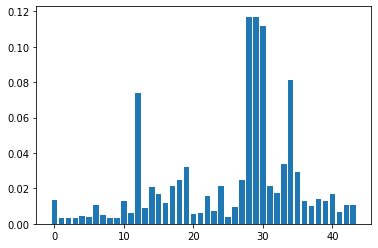

In [346]:
print(pickle_model.feature_importances_)
# plot
plt.bar(range(len(pickle_model.feature_importances_)), pickle_model.feature_importances_)
plt.show()

In [347]:
pkl_filename = 'linear_regr.sav'
with open(pkl_filename, 'rb') as file: 
 model = pickle.load(file) 

In [356]:
df = df.drop(columns = ['buy_post', 'date_diff_post', 'customer_id'])

In [363]:
df.columns[28:31]

Index(['median', 'max', 'std'], dtype='object')

Feature: 0, Score: 0.08410
Feature: 1, Score: 38105959944.45690
Feature: 2, Score: 38835555190.23349
Feature: 3, Score: 38940444431.60765
Feature: 4, Score: 39171954509.90831
Feature: 5, Score: 40969446830.57700
Feature: 6, Score: 42090657356.66000
Feature: 7, Score: 40458777917.33720
Feature: 8, Score: 16554993096.47284
Feature: 9, Score: 26286208958.00700
Feature: 10, Score: 4907217947.50714
Feature: 11, Score: 25252918127.77481
Feature: 12, Score: -0.00365
Feature: 13, Score: -0.29348
Feature: 14, Score: -0.04827
Feature: 15, Score: 0.30208
Feature: 16, Score: 0.32711
Feature: 17, Score: -0.04033
Feature: 18, Score: -0.44040
Feature: 19, Score: -0.04637
Feature: 20, Score: 0.09242
Feature: 21, Score: 0.04954
Feature: 22, Score: -0.11357
Feature: 23, Score: -0.00398
Feature: 24, Score: 0.02987
Feature: 25, Score: -0.06555
Feature: 26, Score: -0.07576
Feature: 27, Score: -8.71107
Feature: 28, Score: 3.23323
Feature: 29, Score: -8.92775
Feature: 30, Score: 16.30028
Feature: 31, Score: 

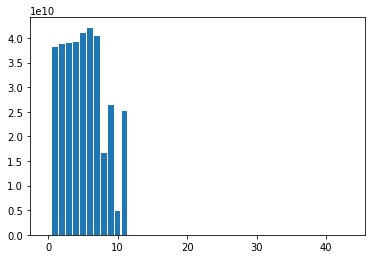

In [349]:
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [325]:
y_pred_proba = pickle_model.predict_proba(X)
probs = pd.DataFrame(y_pred_proba, columns = ['prob_0', 'prob_1'])
probs['customer_id'] = ids
agg_func_probs = {'prob_0': 'mean', 'prob_1': 'mean'}
probs = probs.groupby(['customer_id']).agg(agg_func_probs).reset_index()
probs['buy_post'] = probs.apply(lambda x: 0 if x.prob_0 >= 0.5 else 1, axis = 1)
probs = probs.drop(columns=['prob_1', 'prob_0'])

In [326]:
probs

,customer_id,buy_post
0,29891,1
1,30477,1
2,31426,1
3,44491,1
4,44939,1
...,...,...
499995,46624509,0
499996,46625265,0
499997,46639170,0
499998,46654016,0


In [330]:
probs1 = df.groupby(['customer_id']).agg({'buy_post': 'max'}).reset_index()

In [332]:
y_true = probs1.buy_post
y_score = probs.buy_post

In [338]:
f1_score(y_score, y_true)

0.8379653023412498

In [342]:
metrics.roc_auc_score(y_true, y_score)

0.5981339565657052

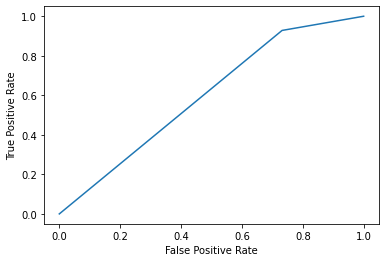

In [343]:
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics. roc_curve (y_true, y_score, drop_intermediate = False)
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [344]:
tpr

array([0.        , 0.92823626, 1.        ])

РЕГРЕССИЯ

In [145]:
df = pd.read_csv('/home/jupyter/datasphere/project/df_train1.csv')

In [146]:
df1 = df.loc[df.buy_post == 1]
X = df1.drop(columns={'customer_id', 'buy_post', 'date_diff_post'})
y = df1.date_diff_post
ids = df1.customer_id
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
X = pd.DataFrame(X_norm)

In [189]:
df1.shape
ids.shape

(2292753,)

In [149]:
(df1.buy_post==0).sum()

0

In [160]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
skf = StratifiedKFold()
rmse = []
xgb = xgb.XGBRegressor()

for train_index, test_index in skf.split(X,y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    #k_n.fit(X_train_fold, y_train_fold)
    #y_pred_fold = k_n.predict(X_test_fold)
    xgb.fit(X_train_fold, y_train_fold)
    y_pred_fold = xgb.predict(X_test_fold)
    rmse.append(mean_squared_error(y_pred_fold, y_test_fold))

KeyboardInterrupt: 

In [176]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
skf = StratifiedKFold()
rmse = []
sgd = SGDRegressor()

for train_index, test_index in skf.split(X,y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    #k_n.fit(X_train_fold, y_train_fold)
    #y_pred_fold = k_n.predict(X_test_fold)
    sgd.fit(X_train_fold, y_train_fold)
    y_pred_fold = sgd.predict(X_test_fold)
    rmse.append(mean_squared_error(y_pred_fold, y_test_fold))

In [178]:
rmse

[188.36941831978461,
 190.03979813524305,
 192.0502162609857,
 192.95785615084023,
 202.43564472403014]

In [179]:
y_pred = xgb.predict(X_1)

In [180]:
mean_squared_error(y_pred, y)

192.97379512646125

In [174]:
mean_squared_error(y_pred, y)

291.8653089778846

In [217]:
y_pred = lr.predict(X)

In [218]:
ids

0             29891
1             29891
2             29891
3             29891
4             29891
             ...   
2880578    46639170
2880579    46639170
2880580    46654016
2880581    46654016
2880582    46654016
Name: customer_id, Length: 2292753, dtype: int64

In [219]:
df_3 = pd.DataFrame(ids)
df_3['date_diff_post'] = y_pred
df_3_group = df_3.groupby(['customer_id']).agg({'date_diff_post':'mean'})
df1_group = df1.groupby(['customer_id']).agg({'date_diff_post':'mean'})

In [223]:
mean_squared_error(df_3_group.date_diff_post, df1_group.date_diff_post)

218.97408204535773

ОТВЕТ ДЛЯ date_diff_post

In [226]:
df_test

,customer_id,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean.1,median.1,max.1,min,std.1,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,0.000000,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
1,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,6.996840,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
2,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,7.042836,499.94,1,0,1,1,1,1,1,0,0,0,0,0,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
3,52341,338.9,0,0,1,0,0,0,0,0,1,0,0,18.030255,655.93,1,1,1,2,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
4,69175,227.3,0,0,0,1,0,0,0,0,0,0,1,0.000000,554.96,1,1,1,0,0,1,1,0,1,0,0,0,0,3.879228,1.006771,13.478299,5.494672,430.306667,399.98,554.96,374.98,62.142941,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592269,46632765,225.0,1,0,0,0,0,0,0,0,0,0,1,0.158218,209.99,0,0,1,0,0,0,0,0,1,0,0,0,0,0.365602,0.158218,0.938588,0.502487,246.650000,239.98,289.98,209.99,40.409983,0,0,0,0,0,0,0,0
592270,46632765,225.0,0,1,0,0,0,0,0,0,1,0,0,0.938588,289.98,1,1,1,0,0,0,0,0,0,0,1,0,0,0.365602,0.158218,0.938588,0.502487,246.650000,239.98,289.98,209.99,40.409983,0,0,0,0,0,0,0,0
592271,46668221,217.4,0,1,0,0,0,0,0,0,0,0,1,0.000000,1344.93,2,0,3,0,1,1,1,0,0,3,0,0,0,0.013029,0.007280,0.031806,0.016664,609.966667,389.98,1344.93,94.99,653.362917,0,0,0,0,0,0,0,1
592272,46668221,217.4,0,1,0,0,0,0,0,0,0,0,1,0.007280,389.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0.013029,0.007280,0.031806,0.016664,609.966667,389.98,1344.93,94.99,653.362917,0,0,0,0,0,0,0,1


In [284]:
ans = pd.read_csv('/home/jupyter/datasphere/project/ans6.csv',sep = ';')

In [288]:
df_bp = ans.drop(columns = ['date_diff_post', 'prob_score'])
prob_score = ans.drop(columns = ['date_diff_post', 'buy_post'])

In [286]:
df_test1 = df_test.merge(df_bp, on='customer_id', how='inner')

In [287]:
df_test2 = df_test1.loc[df_test1.buy_post == 1]
X = df_test2.drop(columns={'customer_id', 'buy_post'})
ids = df_test2.customer_id
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_norm = scaler.transform(X)
X = pd.DataFrame(X_norm)

In [241]:
y_pred_test = lr.predict(X)

In [243]:
len(y_pred_test)

529301

In [254]:
df_4 = pd.DataFrame(ids)
df_4['date_diff_post'] = y_pred_test
df_4_group = df_4.groupby(['customer_id']).agg({'date_diff_post':'mean'}).reset_index()

In [255]:
df_4_group['buy_post'] = 1

In [256]:
df_4_group

,customer_id,date_diff_post,buy_post
0,52341,19.416864,1
1,69175,21.714595,1
2,73427,13.934751,1
3,156357,30.133277,1
4,161390,36.924324,1
...,...,...,...
93908,46313411,25.229200,1
93909,46316874,26.336719,1
93910,46321012,27.946012,1
93911,46460286,26.833780,1


In [262]:
df_test3 = df_test1.loc[df_test1.buy_post == 0]

In [264]:
df_test3['date_diff_post'] = 0

<ipython-input-264-1c5f5af9a1b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test3['date_diff_post'] = 0


In [265]:
df_test3 = df_test3.groupby(['customer_id']).agg({'date_diff_post':'mean'}).reset_index()

In [267]:
df_test3['date_diff_post'] = np.nan

In [269]:
df_test3['buy_post']= 0

In [273]:
df_4_group.head()

,customer_id,date_diff_post,buy_post
0,52341,19.416864,1
1,69175,21.714595,1
2,73427,13.934751,1
3,156357,30.133277,1
4,161390,36.924324,1


In [274]:
df_test3.head()

,customer_id,date_diff_post,buy_post
0,134577,NaN,0
1,180373,NaN,0
2,198380,NaN,0
3,199764,NaN,0
4,201446,NaN,0


In [279]:
df_4_group.append(df_test3)

<ipython-input-279-3db85244d498>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_4_group.append(df_test3)


,customer_id,date_diff_post,buy_post
0,52341,19.416864,1
1,69175,21.714595,1
2,73427,13.934751,1
3,156357,30.133277,1
4,161390,36.924324,1
...,...,...,...
18416,46540272,NaN,0
18417,46569275,NaN,0
18418,46601088,NaN,0
18419,46632765,NaN,0


In [291]:
answer_regr = pd.concat([df_4_group, df_test3]).merge(prob_score,on='customer_id', how='inner')

In [293]:
answer_regr.to_csv('final_answer.csv', sep=';',index =False)

In [295]:
answer_regr

,customer_id,date_diff_post,buy_post,prob_score
0,52341,19.416864,1,0.840510
1,69175,21.714595,1,0.756315
2,73427,13.934751,1,0.985268
3,156357,30.133277,1,0.686239
4,161390,36.924324,1,0.695994
...,...,...,...,...
112329,46540272,NaN,0,0.317212
112330,46569275,NaN,0,0.374042
112331,46601088,NaN,0,0.361267
112332,46632765,NaN,0,0.400002


In [294]:
ans

,customer_id,date_diff_post,buy_post,prob_score
0,52341,1,1,0.840510
1,69175,1,1,0.756315
2,73427,1,1,0.985268
3,134577,1,0,0.465091
4,156357,1,1,0.686239
...,...,...,...,...
112329,46540272,1,0,0.317212
112330,46569275,1,0,0.374042
112331,46601088,1,0,0.361267
112332,46632765,1,0,0.400002


In [270]:
df.date

SyntaxError: invalid syntax (<ipython-input-270-2ea3fe6bf68a>, line 1)

In [207]:
df_3_group

,date_diff_post
customer_id,
29891,15.994120
30477,16.532053
31426,17.567860
44491,28.389891
44939,26.929895
...,...
46598535,27.004817
46609455,26.566551
46617009,27.030781


In [ ]:
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
skf = StratifiedKFold()
rmse = []
lr = LinearRegression()

for train_index, test_index in skf.split(X,y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    #k_n.fit(X_train_fold, y_train_fold)
    #y_pred_fold = k_n.predict(X_test_fold)
    lr.fit(X_train_fold, y_train_fold)
    y_pred_fold = lr.predict(X_test_fold)
    rmse.append(mean_squared_error(y_pred_fold, y_test_fold))

In [107]:
y_pred = xgb.predict(X)

In [104]:
df['buy_post'] = y_pred

In [109]:
agg_func = {'buy_post':'mean'}
df_copy = df.groupby(['customer_id']).agg(agg_func).reset_index()

In [111]:
df = df.drop(columns=['buy_post'])

In [112]:
df = df.merge(df_copy, on='customer_id', how='inner')

In [116]:
df.buy_post = df.buy_post.round()

In [118]:
df.buy_post.unique()

array([1., 0.])

In [119]:
df.head()

,customer_id,date_diff_post,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean.1,median.1,max.1,min,std.1,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом,buy_post
0,29891,9.0,300.0,1,0,0,0,0,0,0,0,1,0,0,0.000000,389.97,1,1,1,0,0,0,1,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,1,0,0,0,0,0,0,1.0
1,29891,9.0,300.0,1,0,0,0,0,0,0,0,1,0,0,0.100428,119.99,0,0,0,0,1,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,1,0,0,0,0,0,0,1.0
2,29891,9.0,463.0,0,0,0,1,0,0,0,0,0,1,0,9.422731,269.99,0,0,2,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,0,0,0,0,1,0,0,1.0
3,29891,9.0,463.0,0,1,0,0,0,0,0,1,0,0,0,5.363414,144.97,0,0,1,0,0,0,0,0,0,0,0,1,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,0,0,0,0,1,0,0,1.0
4,29891,9.0,463.0,0,0,1,0,0,0,0,1,0,0,0,1.017882,184.96,0,0,1,0,0,0,0,0,0,0,0,0,0,2.316445,1.002199,11.122106,3.022503,203.494,199.96,439.98,1.0,123.170275,0,0,0,0,0,1,0,0,1.0


In [135]:
X = df.drop(columns={'date_diff_post'})
y = df.date_diff_post
'''from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
X = pd.DataFrame(X_norm)
type(sgdc)'''

'from sklearn.preprocessing import StandardScaler\nfrom sklearn.preprocessing import MinMaxScaler\n\nscaler = StandardScaler()\nscaler.fit(X)\nX_norm = scaler.transform(X)\nX = pd.DataFrame(X_norm)\ntype(sgdc)'

In [136]:
X_0 = X.loc[X.buy_post == 0]
X = X.loc[X.buy_post == 1]

In [137]:
X.buy_post.unique()

array([1.])

In [138]:
X_0

,customer_id,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean.1,median.1,max.1,min,std.1,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом,buy_post
199,45404,315.1,0,0,0,0,0,1,0,0,1,0,0,0.000000,2134.91,1,4,3,0,0,5,1,0,0,0,0,1,0,3.691219,0.590208,10.483449,5.889642,772.633333,176.99,2134.91,6.00,1182.859959,1,0,0,0,0,0,0,0,0.0
200,45404,231.9,0,0,1,0,0,0,0,0,0,1,0,10.483449,176.99,1,2,1,0,0,2,0,0,0,0,0,0,0,3.691219,0.590208,10.483449,5.889642,772.633333,176.99,2134.91,6.00,1182.859959,0,0,0,0,1,0,0,0,0.0
201,45404,231.9,0,0,1,0,0,0,0,0,1,0,0,0.590208,6.00,1,1,1,1,0,2,0,0,0,0,0,0,0,3.691219,0.590208,10.483449,5.889642,772.633333,176.99,2134.91,6.00,1182.859959,0,0,0,0,1,0,0,0,0.0
315,119045,144.4,0,0,0,0,0,0,1,0,0,0,1,0.000000,615.95,1,0,1,0,0,1,0,0,0,0,0,0,0,0.006736,0.007812,0.012396,0.006268,396.970000,314.98,615.95,259.98,191.625756,0,0,0,0,0,0,0,1,0.0
316,119045,144.4,0,0,0,0,0,0,1,0,0,0,1,0.007812,314.98,0,0,1,0,0,1,0,0,0,0,0,0,0,0.006736,0.007812,0.012396,0.006268,396.970000,314.98,615.95,259.98,191.625756,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880581,46654016,270.0,0,1,0,0,0,0,0,0,1,0,0,0.076979,179.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140,0,0,0,0,0,1,0,0,0.0
2880582,46654016,270.0,0,1,0,0,0,0,0,0,0,0,1,0.174340,569.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0.083773,0.076979,0.174340,0.087368,406.643333,469.96,569.98,179.99,202.558140,0,0,0,0,0,1,0,0,0.0
2880583,46661804,300.0,0,1,0,0,0,0,0,0,1,0,0,0.000000,259.99,1,1,1,0,0,0,0,0,0,0,1,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345,0,0,0,0,0,0,0,1,0.0
2880584,46661804,300.0,0,1,0,0,0,0,0,0,0,0,1,0.007801,284.97,1,1,1,1,0,2,0,0,0,0,0,0,0,0.003356,0.002269,0.007801,0.004013,278.310000,284.97,289.97,259.99,16.061345,0,0,0,0,0,0,0,1,0.0


In [139]:
ids_1 = X.customer_id
ids_0 = X_0.customer_id

0             29891
1             29891
2             29891
3             29891
4             29891
             ...   
2880425    46481424
2880426    46481424
2880491    46511228
2880492    46511228
2880493    46511228
Name: customer_id, Length: 2657709, dtype: int64

In [85]:
ans = ans.drop(columns=['prob_score', 'date_diff_post'])

In [87]:
ans.head()

,customer_id,buy_post
0,52341,1
1,69175,1
2,73427,1
3,134577,0
4,156357,1


In [88]:
df_copy = X.merge(X, on='customer_id', how='inner')

KeyError: 'customer_id'

In [ ]:
df.head()

In [60]:
df_test = pd.read_csv('/home/jupyter/datasphere/project/df_test_nenorm.csv')

In [61]:
df_test.head()

,customer_id,ownareaall_sqm,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_morning,is_day,is_night,is_evening,until_days,revenue,contains_fries,contains_cold_drinks,contains_burgers,contains_deserts,contains_hot_drinks,contains_snacks,contains_sauces,contains_kids,spicy_flavour,cheese_flavour,double_flavour,chicken_flavour,fish_flavour,mean,median,max,std,mean.1,median.1,max.1,min,std.1,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,0.000000,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
1,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,6.996840,549.95,1,1,1,1,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
2,52341,338.9,0,0,0,0,0,1,0,0,1,0,0,7.042836,499.94,1,0,1,1,1,1,1,0,0,0,0,0,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
3,52341,338.9,0,0,1,0,0,0,0,0,1,0,0,18.030255,655.93,1,1,1,2,1,1,1,0,0,0,0,1,0,8.017483,7.019838,18.030255,7.450442,563.942500,549.95,655.93,499.94,65.700330,0,0,0,0,0,1,0,0
4,69175,227.3,0,0,0,1,0,0,0,0,0,0,1,0.000000,554.96,1,1,1,0,0,1,1,0,1,0,0,0,0,3.879228,1.006771,13.478299,5.494672,430.306667,399.98,554.96,374.98,62.142941,0,1,0,0,0,0,0,0


In [62]:
ids = df_test.customer_id

In [63]:
X = df_test.drop(columns=['customer_id'])

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_norm = scaler.transform(X)
X = pd.DataFrame(X_norm)

In [65]:
y_pred = sgdc.predict(X)

In [67]:
y_pred_proba = xgb.predict_proba(X)
probs = pd.DataFrame(y_pred_proba, columns = ['prob_0', 'prob_1'])
probs['customer_id'] = pd.Series(ids)
probs['date_diff_post'] = 1
agg_func_probs = {'prob_0': 'mean', 'prob_1': 'mean'}
probs = probs.groupby(['customer_id', 'date_diff_post']).agg(agg_func_probs).reset_index()
probs['buy_post'] = probs.apply(lambda x: 0 if x.prob_0 >= 0.5 else 1, axis = 1)
probs['prob_score'] = probs.prob_1
probs = probs.drop(columns=['prob_1', 'prob_0'])

In [68]:
probs

,customer_id,date_diff_post,buy_post,prob_score
0,52341,1,1,0.840510
1,69175,1,1,0.756315
2,73427,1,1,0.985268
3,134577,1,0,0.465091
4,156357,1,1,0.686239
...,...,...,...,...
112329,46540272,1,0,0.317212
112330,46569275,1,0,0.374042
112331,46601088,1,0,0.361267
112332,46632765,1,0,0.400002


In [69]:
(probs.buy_post==0).sum()

18421

In [71]:
probs.to_csv('ans6.csv', index = False, sep=';')

In [57]:
#df_test = df_test.drop(columns=['group_name','prev_id', 'prev_time'])
df_copy = df_test.copy()
df_copy = df_copy.drop(columns=['dish_name']) 

In [58]:
agg_func = {'until_days': 'sum', 'revenue': 'sum', 'contains_fries': 'sum','contains_cold_drink': 'sum', 'contains_burger': 'sum', 'contains_desert': 'sum',\
           'contains_hot_drink': 'sum', 'contains_snack': 'sum', 'contains_sauce': 'sum'}
df_copy = df_copy.groupby(['customer_id', 'startdatetime', 'ownareaall_sqm', 'format_name']).agg(agg_func).reset_index()
df_copy = pd.get_dummies(df_copy, columns =['format_name'])

In [59]:
df_copy.head()

,customer_id,startdatetime,ownareaall_sqm,until_days,revenue,contains_fries,contains_cold_drink,contains_burger,contains_desert,contains_hot_drink,contains_snack,contains_sauce,format_name_Не заполнено,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,52341,2023-02-04 13:13:06,338.9,0.000000,549.95,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0
1,52341,2023-02-11 13:08:33,338.9,6.996840,549.95,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0
2,52341,2023-02-18 14:10:14,338.9,7.042836,499.94,1,0,1,1,1,1,1,0,0,0,0,0,0,1,0,0
3,52341,2023-03-08 14:53:48,338.9,18.030255,655.93,1,1,1,2,1,1,1,0,0,0,0,0,0,1,0,0
4,69175,2023-06-22 21:11:54,227.3,0.000000,554.96,1,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0


In [60]:
df_copy = df_copy.drop(columns = ['startdatetime', 'format_name_Не заполнено'])

In [61]:
df_copy

,customer_id,ownareaall_sqm,until_days,revenue,contains_fries,contains_cold_drink,contains_burger,contains_desert,contains_hot_drink,contains_snack,contains_sauce,format_name_Отдельно стоящий,format_name_Отдельно стоящий без внешней зоны,format_name_Отдельно стоящий без внешней зоны без туалета,format_name_Отдельно стоящий без туалета,format_name_Отдельно стоящий с внешн.зоной без туалета,format_name_Отдельно стоящий с внешней зоной,format_name_Фудкорт без туалета,format_name_Фудкорт с туалетом
0,52341,338.9,0.000000,549.95,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0
1,52341,338.9,6.996840,549.95,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0
2,52341,338.9,7.042836,499.94,1,0,1,1,1,1,1,0,0,0,0,0,1,0,0
3,52341,338.9,18.030255,655.93,1,1,1,2,1,1,1,0,0,0,0,0,1,0,0
4,69175,227.3,0.000000,554.96,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592269,46632765,225.0,0.158218,209.99,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
592270,46632765,225.0,0.938588,289.98,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
592271,46668221,217.4,0.000000,1344.93,2,0,3,0,1,1,1,0,0,0,0,0,0,0,1
592272,46668221,217.4,0.007280,389.98,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1


In [62]:
ids = df_copy.customer_id
df_copy = df_copy.drop(columns=['customer_id'])


In [64]:
y_pred = log.predict(df_copy)
y_pred_proba = log.predict_proba(df_copy)

In [65]:
(y_pred == 0).sum()

64

In [51]:
probs = pd.DataFrame(y_pred_proba, columns = ['prob_0', 'prob_1'])
probs['customer_id'] = pd.Series(ids)
probs['date_diff_post'] = 1
agg_func_probs = {'prob_0': 'mean', 'prob_1': 'mean'}
probs = probs.groupby(['customer_id', 'date_diff_post']).agg(agg_func_probs).reset_index()
probs['buy_post'] = probs.apply(lambda x: 0 if x.prob_0 >= 0.5 else 1, axis = 1)
probs['prob_score'] = probs.prob_1
probs = probs.drop(columns=['prob_1', 'prob_0'])

In [52]:
(probs.buy_post==1).sum()

94015

In [71]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(log, open(filename, 'wb'))

In [99]:
probs.to_csv('ans3.csv', index = False, sep=';')

In [74]:
df_test1 = pd.read_parquet('/home/jupyter/datasphere/project/hackaton2023_test.gzip')

In [75]:
len(df_test1.customer_id.unique())

112334

In [76]:
len(probs)

112334

In [95]:
probs

,customer_id,date_diff_post,buy_post,prob_score
0,52341,1,1,0.831019
1,69175,1,1,0.782381
2,73427,1,1,0.781680
3,134577,1,1,0.779990
4,156357,1,1,0.821941
...,...,...,...,...
112329,46540272,1,1,0.779893
112330,46569275,1,1,0.787463
112331,46601088,1,1,0.795973
112332,46632765,1,1,0.762966


In [ ]:
probs['date_diff_post'] = probs.apply(lambda x: np.nan if x.buy_post==0 else probs.date_diff_post, axis = 1)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
#from catboost import CatBoostClassifier

log = LogisticRegression()
tree = DecisionTreeClassifier()
svc = SVC()
knn = KNeighborsClassifier()
xgb = xgb.XGBClassifier()
#catboost = CatBoostClassifier()

models = [log, tree, svc, knn, xgb]

In [48]:
from sklearn.metrics import f1_score

f1 = []
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    f1.append(f1_score(y_val, y_pred))

587833